In [1]:
import math

import jax
import jax.numpy as jnp
from jax import grad, random, vmap

from utils import *
from kernels import *

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.ndimage import gaussian_filter


In [50]:
def get_rotation_params(K, T, key):
    time = jnp.linspace(0, 2 *jnp.pi, T)[:, jnp.newaxis] #4
    radii = jnp.linspace(0.1, 2, K)
    radii = random.permutation(key, radii)
    phases = jnp.linspace(0, 2*jnp.pi, K)
    return time, radii, phases

def get_rotations(K, T, key):
    time, radii, phases = get_rotation_params(K, T, key)

    sine_waves = jnp.sin(time + phases) * radii
    cosine_waves = jnp.cos(time + phases) * radii
    X = jnp.stack([cosine_waves.T, sine_waves.T], axis=1)  
    return X

def get_infty_traj(K, T, key):
    time, radii, phases = get_rotation_params(K, T, key)

    r = radii * jnp.cos(time + phases)
    theta = radii * jnp.sin(time + phases)
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    X = jnp.stack([x.T, y.T], axis=1)
    return X

def get_expansions(K, T, key, oneD=False):
    if oneD == False:
        initial_rates = 0.05 * (random.uniform(key, shape=(K, 2, 1)) - 0.5)
    else:
        initial_rates = 0.1 * (random.uniform(key, shape=(K, 1, 1)) - 0.5)
    time_steps = jnp.arange(T)
    X = jnp.exp(initial_rates * time_steps)
    return X

def rotation_system(t, y):
    x1, x2 = y
    dx1_dt = - x2 
    dx2_dt = x1 
    return [dx1_dt, dx2_dt]

def pendulum_system(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = -np.sin(x1) 
    return [dx1_dt, dx2_dt]

def duffing_oscillator(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = x1 - x1**3 
    return [dx1_dt, dx2_dt]

def van_der_pol(t, y):
    x1, x2 = y
    dx1_dt = x2 
    dx2_dt = (1 - x1**2) * x2 - x1 
    return [dx1_dt, dx2_dt]

def get_oscillator(K, T, seed = 42, type=van_der_pol):
    np.random.seed(seed) 
    initial_conditions_list = np.random.uniform(low=-np.pi, high=np.pi, size=(K, 2))

    t_span = (0, 10)   
    t_eval = np.linspace(t_span[0], t_span[1], T)  
    X = np.zeros((K, 2, T))
    for i, initial_conditions in enumerate(initial_conditions_list):
        solution = solve_ivp(type, t_span, initial_conditions, t_eval=t_eval)
        x1 = solution.y[0]
        x2 = solution.y[1]

        X[i, 0, :] = x1
        X[i, 1, :] = x2
    X = jnp.array(X)
    return X

def project_X(X, key, proj_dims = 100):
    proj_matrix = random.normal(key, (proj_dims, X.shape[1]))
    proj_matrix , _ = jnp.linalg.qr(proj_matrix)                    #(N',N)
    X = jnp.einsum('lj,ijk->ilk', proj_matrix, X)                   #(K, N', T)
    return X

def add_isotropic_noise(X, key):
    noise = random.normal(key, (X.shape)) 
    X += 0.01 * (noise) 
    return X 

def add_random_modes(X, key1, key2, mean=0, std_dev=1):
    K, _, T = X.shape
    trajectories_1 = random.normal(key1, (K, T), dtype=X.dtype) * std_dev + mean
    trajectories_2 = random.normal(key2, (K, T), dtype=X.dtype) * std_dev + mean
    combined_trajectories = jnp.stack((trajectories_1, trajectories_2), axis=1)
    X = jnp.concatenate((X, combined_trajectories), axis=1)
    return X

def add_low_rank_noise(X, key1, key2, proj_dims = 3, sigma = 0.75 ):
    K, N, T = X.shape    
    B = random.normal(key1, (N, proj_dims))
    B, _ = jnp.linalg.qr(B)

    epsilon_t = random.normal(key2, (K, T, proj_dims)) * sigma  
    noise = jnp.einsum('ktd,nd->knt', epsilon_t, B)             
    
    X += noise                                                   
    return X

def apply_gaussian_smoothing(data, sigma=1, axes=-1):
    smoothed_data = gaussian_filter(np.array(data), sigma=sigma, axes=axes)
    return jnp.array(smoothed_data)



(100, 2, 50)
(100, 100, 50)
0.80080825
0.9819322


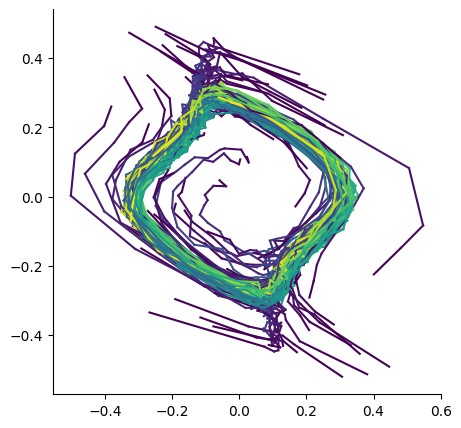

In [57]:
seed = 41
key = random.PRNGKey(seed)
key1, key2, key3, key4 = random.split(key, 4)

K = 100
T = 50
split = 20
d = 2 
c=30

# X = get_infty_traj(K, T, key1)
# print(X.shape)
# X = project_X(X, key2)
# print(X.shape)
# X = add_low_rank_noise(X, key3, key4)
X = get_oscillator(K, T)
print(X.shape)
X = project_X(X, key2)
print(X.shape)
X = add_isotropic_noise(X, key3)

X_train=X[split:]
X_test=X[:split]
K, N, T = X_train.shape
A = jnp.swapaxes(X_train, 0, 1)                  #(N, K, T)
A = A.reshape(N,-1)                              #(N, K*T)


plot_2D(center(X_train))

print(np.mean(compute_S(X_train)))
print(compute_S_all_pairs(X_test))

In [116]:
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/X_train', X_train )
np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/X_test', X_test )

Iteration 0, S: 0.013990813866257668, S_ratio: 0.07792314141988754
Iteration 10, S: 5.117851734161377, S_ratio: 0.6632518172264099
Iteration 20, S: 9.825456619262695, S_ratio: 0.6833412051200867
Iteration 30, S: 9.74980640411377, S_ratio: 0.6799207925796509
Iteration 40, S: 10.204405784606934, S_ratio: 0.69621342420578
Iteration 50, S: 12.968314170837402, S_ratio: 0.7858193516731262
Iteration 60, S: 12.438714981079102, S_ratio: 0.7089979648590088
Iteration 70, S: 11.764033317565918, S_ratio: 0.6759570837020874
Iteration 80, S: 14.722164154052734, S_ratio: 0.7208223342895508
Iteration 90, S: 9.711681365966797, S_ratio: 0.6703668236732483


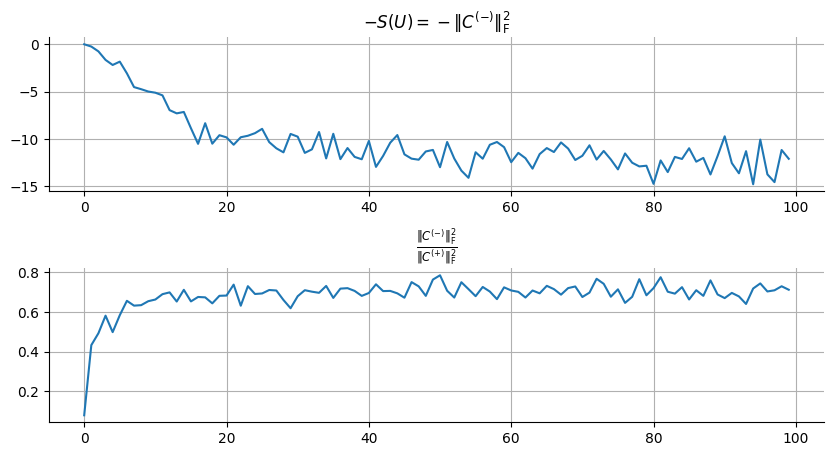

In [46]:
kernel_function=K_X_Y_rational_quadratic
d = 2

from kernel_sca_inducing_points import *
wandb.init(project="", name="", mode="disabled")
params, ls_loss, ls_S_ratio = optimize(X_train, A, iterations=100, learning_rate=0.1, d=d, c=c, kernel_function=kernel_function)
wandb.finish()

get_loss_fig(ls_loss, ls_S_ratio )




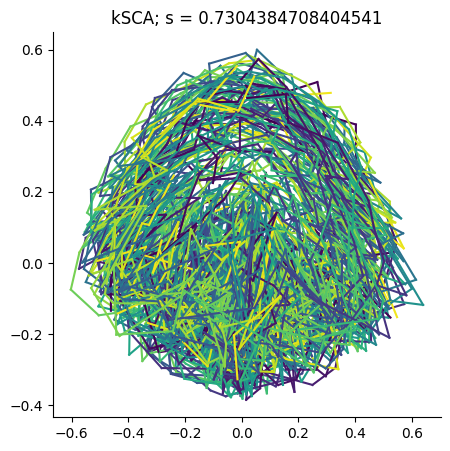

<Figure size 640x480 with 0 Axes>

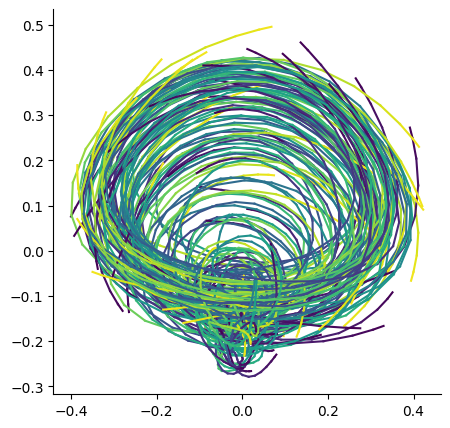

In [47]:
_, u, l2, scale = get_params(params, kernel_function=kernel_function)
K_u_u_K_u_A_alpha_H, K_A_u, K_u_u  = get_alpha(params, A, X_train, kernel_function, d)

K_test, _, _ = X_test.shape
X_reshaped = X_train.swapaxes(0,1).reshape(N,-1)
K_u_X = kernel_function(u, X_reshaped, l2=l2, scale=scale).reshape(-1,K,T).swapaxes(0,1)  
Y = jnp.einsum('ji,kjm->kim',  K_u_u_K_u_A_alpha_H, K_u_X)
Y = center(Y)

plot_2D(Y[:,:,:])
plt.title(f'kSCA; s = {compute_S_all_pairs(Y)}')

Y_smoothed = apply_gaussian_smoothing(Y, sigma=3)
plt.figure()
plot_2D(Y_smoothed)
# def var_explained_kernel(K_u_u_K_u_A_alpha_H, K_A_u, K_u_u):
#     return  np.trace( K_u_u_K_u_A_alpha_H.T @ K_u_u_K_u_A_alpha_H / np.trace(K_A_u @ K_u_u @ K_A_u.T )   ) #

# print(var_explained_kernel(K_u_u_K_u_A_alpha_H, K_A_u, K_u_u))

#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/rational quadratic/Y_train', Y)
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/rational quadratic/ls_loss', np.array(ls_loss))
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/rational quadratic/ls_S_ratio', np.array(ls_S_ratio))

Iteration 0, S: 0.10510170459747314, S_ratio: 0.1311788707971573
Iteration 10, S: 0.32182860374450684, S_ratio: 0.12824298441410065
Iteration 20, S: 1.0918407440185547, S_ratio: 0.15880686044692993
Iteration 30, S: 1.869146466255188, S_ratio: 0.15177121758460999
Iteration 40, S: 4.095114707946777, S_ratio: 0.16341395676136017
Iteration 50, S: 7.306087493896484, S_ratio: 0.16246101260185242
Iteration 60, S: 9.923246383666992, S_ratio: 0.15588976442813873
Iteration 70, S: 15.932737350463867, S_ratio: 0.1651412695646286
Iteration 80, S: 20.208986282348633, S_ratio: 0.1649167537689209
Iteration 90, S: 25.654817581176758, S_ratio: 0.17382647097110748
Iteration 100, S: 24.711992263793945, S_ratio: 0.1452142596244812
Iteration 110, S: 31.114980697631836, S_ratio: 0.15857797861099243
Iteration 120, S: 33.39501953125, S_ratio: 0.1482362002134323
Iteration 130, S: 33.570899963378906, S_ratio: 0.14189139008522034
Iteration 140, S: 34.33827590942383, S_ratio: 0.14153075218200684
Iteration 150, S: 

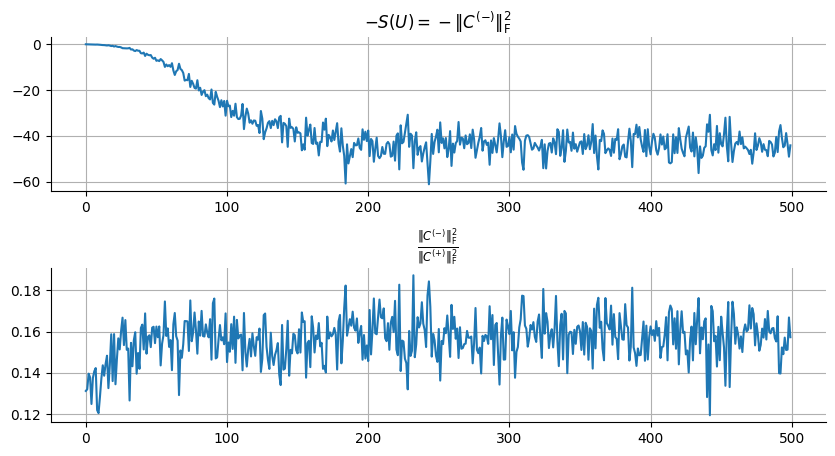

In [53]:
from linear_sca import *
wandb.init(project="", name="", mode="disabled")
U, ls_loss, ls_S_ratio = optimize(center(X_train), d=d, learning_rate=0.01, iterations=500) 
wandb.finish

get_loss_fig(ls_loss, ls_S_ratio )


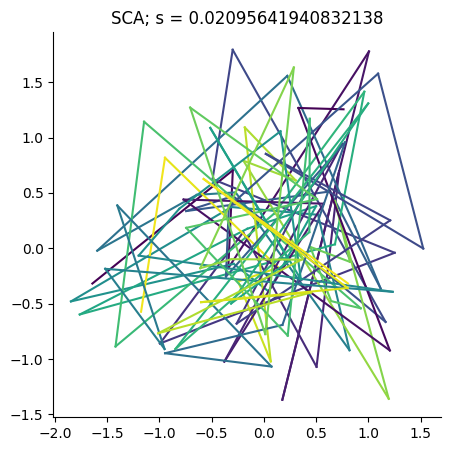

<Figure size 640x480 with 0 Axes>

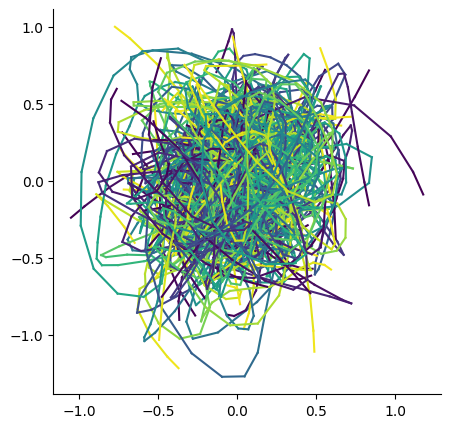

In [54]:

U_qr, _ = jnp.linalg.qr(U)        
Y = jnp.einsum('ji,kjl->kil', U_qr, center(X_train))
plot_2D(Y[:2,:,:])
plt.title(f'SCA; s = {compute_S_all_pairs(Y)}')

Y_smoothed = apply_gaussian_smoothing(Y, sigma=2)
plt.figure()
plot_2D(Y_smoothed)
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/linear/Y_test', Y)
# np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/linear/ls_loss', np.array(ls_loss))
# np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/linear/ls_S_ratio', np.array(ls_S_ratio))

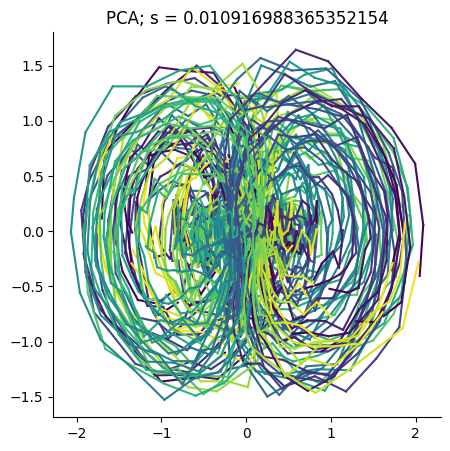

<Figure size 640x480 with 0 Axes>

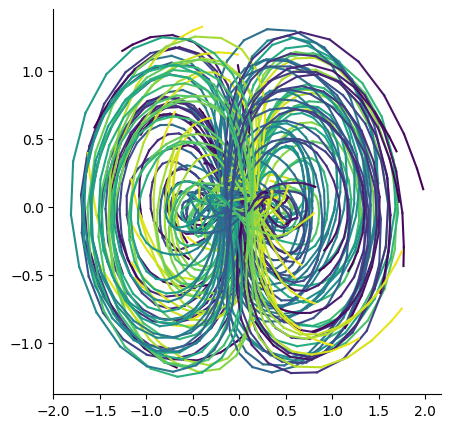

In [43]:
""" PCA """
X_pca_train = center(X_train).swapaxes(1,2).reshape(-1, N)
X_pca_test = center(X_test).swapaxes(1,2).reshape(-1, N)

num_pcs = 2
pca = PCA(num_pcs)
Y_pca = pca.fit(X_pca_train).transform(X_pca_train)
PCs = pca.components_
Y_pca = Y_pca.reshape(-1, T, num_pcs).swapaxes(1,2)
pca_variance_captured = pca.explained_variance_ratio_

plot_2D(Y_pca)
#plt.title(f"pca {var_explained(X, PCs[:2].T):.2f}")
plt.title(f'PCA; s = {compute_S_all_pairs(jnp.array(Y_pca))}')
Y_smoothed = apply_gaussian_smoothing(Y_pca, sigma=2)
plt.figure()
plot_2D(Y_smoothed)
#np.save('/Users/ariellerosinski/My Drive/Cambridge/Project/outputs/toy datasets/1D exp + obs noise/pca/Y_train', Y_pca)

In [ ]:
compute_S_all_pairs(jnp.array(Y_pca))